## Exercice 2.3

In [1]:
import tensorflow as tf

### Chargement et prétraitement des données

In [5]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalisation des pixels (valeurs entre 0 et 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Shape x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"Shape x_test: {x_test.shape}, y_test: {y_test.shape}")


Shape x_train: (50000, 32, 32, 3), y_train: (50000, 1)
Shape x_test: (10000, 32, 32, 3), y_test: (10000, 1)


Augmentation des données d'entrainement pour rendre le modèle plus robuste

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Générateur d'augmentation (rotation, décalage, zoom)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(x_train)

augmented_data = []
augmented_labels = []

# Générer des données augmentées et les collecter
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32, shuffle=False):
    augmented_data.append(x_batch)
    augmented_labels.append(y_batch)
    if len(augmented_data) * 32 >= len(x_train):  
        break

x_train_augmented = np.concatenate(augmented_data, axis=0)
y_train_augmented = np.concatenate(augmented_labels, axis=0)
x_train_combined = np.concatenate((x_train, x_train_augmented), axis=0)
y_train_combined = np.concatenate((y_train, y_train_augmented), axis=0)

print(f"Dimensions des données d'entraînement d'origine : {x_train.shape}")
print(f"Dimensions des données augmentées : {x_train_augmented.shape}")
print(f"Dimensions des données combinées : {x_train_combined.shape}")


Dimensions des données d'entraînement d'origine : (50000, 32, 32, 3)
Dimensions des données augmentées : (50000, 32, 32, 3)
Dimensions des données combinées : (100000, 32, 32, 3)


### Création d'un Modèle de Réseau de Neurones Concolutif

- 3 couches de convolution avec plusieurs filtres : 32, 64, 128 avec activation ReLU
- Couches de Pooling pour diminuer la complexité (diminue les dimensions et le nombre de paramètres pour éviter le surapprentissage)
- Aplatissement
- 2 couches denses de respectivement 128 et 10 neurones
- dropout pour éviter le surapprentissage 

In [4]:
from tensorflow.keras import models, layers

model_cnn = models.Sequential()

model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))

model_cnn.add(layers.MaxPooling2D((2, 2)))

model_cnn.add(layers.Flatten())

model_cnn.add(layers.Dense(128, activation='relu'))
model_cnn.add(layers.Dropout(0.5)) 
model_cnn.add(layers.Dense(10, activation='softmax'))

C:\Users\vpica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Entrainement et optimisation du modèle 

In [ ]:
model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['sparse_categorical_accuracy'])  

# Entraînement du modèle avec les données combinées 
history = model_cnn.fit(x_train_combined, y_train_combined, epochs=15, batch_size=32, validation_data=(x_test, y_test))

### Evaluation et analyse des performances

- Accuracy globale et Test Loss global
- Rapport de Classification
- Heatmap de la Matrice de Confusion

313/313 - 1s - 3ms/step - loss: 0.7691 - sparse_categorical_accuracy: 0.7540
Test Accuracy: 0.7540000081062317
Test Loss: 0.7690712213516235
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Rapport de classification:
              precision    recall  f1-score   support

           0       0.72      0.84      0.77      1000
           1       0.85      0.89      0.87      1000
           2       0.67      0.65      0.66      1000
           3       0.60      0.55      0.57      1000
           4       0.73      0.72      0.72      1000
           5       0.68      0.63      0.66      1000
           6       0.79      0.81      0.80      1000
           7       0.78      0.79      0.79      1000
           8       0.89      0.81      0.85      1000
           9       0.81      0.85      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



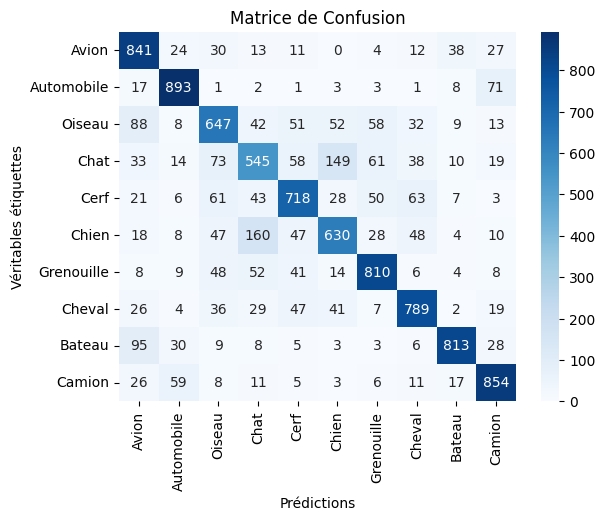

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_loss, test_acc = model_cnn.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

y_pred = model_cnn.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

print("\nRapport de classification:")
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)

class_names = ['Avion', 'Automobile', 'Oiseau', 'Chat', 'Cerf', 'Chien', 'Grenouille', 'Cheval', 'Bateau', 'Camion']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Véritables étiquettes")
plt.show()
